In [1]:
import pickle
from pathlib import Path
import numpy as np
import gurobipy as gp; gp.Model()

from src.input import Input_uc, Input_suc, get_min_up_down_initials
from src.output import Output_uc
from src.unit_commitment import solve_uc
from src.stochastic_unit_commitment import solve_suc

Set parameter Username
Set parameter LicenseID to value 2659802
Academic license - for non-commercial use only - expires 2026-05-01


In [2]:
def load_data():
    path_folder_processed = Path.cwd() / "data" / "input" / "processed"
    timestamp_2022 = np.load(path_folder_processed / "timestamp_2022.npy")
    
    global num_units, num_periods, time_start
    num_units = 122
    num_periods = 24
    time_start, time_end = np.datetime64("2022-07-21T00"), np.datetime64("2022-07-21T23")
    idx_time_start, idx_time_end = np.where(timestamp_2022 == time_start)[0][0], np.where(timestamp_2022 == time_end)[0][0]

    global unit_type, idx_nuclear, idx_coal, idx_lng
    unit_type = np.load(path_folder_processed / "unit_type.npy")
    idx_nuclear = np.load(path_folder_processed / "idx_nuclear.npy")
    idx_coal = np.load(path_folder_processed / "idx_coal.npy")
    idx_lng = np.load(path_folder_processed / "idx_lng.npy")

    global p_min, p_max, ramp_up, ramp_down, startup_ramp, shutdown_ramp, min_up, min_down
    p_min = np.load(path_folder_processed / "p_min.npy")
    p_max = np.load(path_folder_processed / "p_max.npy")
    ramp_up = np.load(path_folder_processed / "ramp_up.npy")
    ramp_down = np.load(path_folder_processed / "ramp_down.npy")
    startup_ramp = np.load(path_folder_processed / "startup_ramp.npy")
    shutdown_ramp = np.load(path_folder_processed / "shutdown_ramp.npy")
    min_up = np.load(path_folder_processed / "min_up.npy")
    min_down = np.load(path_folder_processed / "min_down.npy")

    global cost_lin, cost_const, cost_startup_step_old, num_cooling_steps_old, cost_startup_step, step_length
    cost_lin = np.load(path_folder_processed / "cost_lin.npy")
    cost_const = np.load(path_folder_processed / "cost_const.npy")
    cost_startup_step_old = pickle.load(open(path_folder_processed / "cost_startup_step_old.pkl", "rb"))
    num_cooling_steps_old = np.load(path_folder_processed / "num_cooling_steps_old.npy")
    cost_startup_step = np.load(path_folder_processed / "cost_startup_step.npy")
    step_length = np.load(path_folder_processed / "step_length.npy")

    global demand, renewable
    demand = np.load(path_folder_processed / "demand_2022.npy")[idx_time_start:idx_time_end+1]
    renewable = np.load(path_folder_processed / "renewable_gen_2022.npy")[idx_time_start:idx_time_end+1]

    global p_prev, u_prev, min_up_r, min_down_r, min_up_0, min_down_0
    p_prev = np.load(path_folder_processed / "p_prev.npy")
    u_prev = np.load(path_folder_processed / "u_prev.npy")
    min_up_r = np.load(path_folder_processed / "min_up_r.npy")
    min_down_r = np.load(path_folder_processed / "min_down_r.npy")
    min_up_0 = np.load(path_folder_processed / "min_up_0.npy")
    min_down_0 = np.load(path_folder_processed / "min_down_0.npy")

    global thermal_demand_scenario
    thermal_demand_scenario = np.load(path_folder_processed / "thermal_demand_2022721_tk.npy")

In [3]:
load_data()

In [4]:
input_uc = Input_uc(
    # meta
    unit_type=unit_type,
    idx_nuclear=idx_nuclear,
    idx_coal=idx_coal,
    idx_lng=idx_lng,
    num_units=num_units,
    num_periods=num_periods,
    # system
    demand=demand,
    reserve=None,
    renewable=renewable, # probably will use for the last stage RT evaluation
    # generator
    p_min=p_min,
    p_max=p_max,
    ramp_up=ramp_up,
    ramp_down=ramp_down,
    startup_ramp=startup_ramp,
    shutdown_ramp=shutdown_ramp,
    min_up=min_up,
    min_down=min_down,
    # cost function - generation
    cost_lin=cost_lin,
    cost_const=cost_const,
    # cost function - startup (paper formulation)
    cost_startup_step=cost_startup_step,
    step_length=step_length,
    # cost function - startup (lecture note formulation)
    cost_startup_step_old=cost_startup_step_old,
    num_cooling_steps_old=num_cooling_steps_old,
    # initial conditions
    p_prev=p_prev,
    u_prev=u_prev,
    min_up_r=min_up_r,
    min_down_r=min_down_r,
    min_up_0=min_up_0,
    min_down_0=min_down_0,
)

input_suc_case1 = Input_suc(
    demand_fore=demand,# testing that forecast = actual
    renewable_fore=renewable, # testing that forecast = actual
    num_scenarios=6,
    thermal_demand_scenario=thermal_demand_scenario,
    scenario_p_weight=np.ones(6) / 6,
    voll=3500000,
    fr_margin_pu=0.02,
)


In [5]:
output_suc_case1 = Output_uc()
solve_suc(
    input_uc=input_uc,
    input_suc=input_suc_case1,
    output_suc=output_suc_case1,
    verbose=True,
)

Set parameter OutputFlag to value 1
Set parameter Symmetry to value 2
Set parameter PreDual to value 2
Set parameter Presolve to value 1
Set parameter PreSparsify to value 2
Set parameter Disconnected to value 2
Set parameter Heuristics to value 1
Set parameter ProjImpliedCuts to value 2
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Arch Linux")

CPU model: 12th Gen Intel(R) Core(TM) i7-12700, instruction set [SSE2|AVX|AVX2]
Thread count: 20 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
Disconnected  2
Heuristics  1
Symmetry  2
ProjImpliedCuts  2
PreDual  2
Presolve  1
PreSparsify  2

Optimize a model with 105622 rows, 38376 columns and 379337 nonzeros
Model fingerprint: 0xf875783f
Variable types: 20808 continuous, 17568 integer (17568 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [6e+02, 6e+07]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+00, 9e+04]
Sparsify removed 2170 nonzeros

In [6]:
import pickle

path_ouptut = Path.cwd() / "data" / "output"
with open(path_ouptut / "output_suc_case1.pickle", "wb") as f:
    pickle.dump(output_suc_case1, f, pickle.HIGHEST_PROTOCOL) # saving cus i will definitely have to restart this ipynb for orignal DUC stuffs


In [7]:
from src.stochastic_unit_commitment import solve_ed_after_suc
path_ouptut = Path.cwd() / "data" / "output"
with open(path_ouptut / "output_suc_case1.pickle", "rb") as f:
    output_suc_case1 = pickle.load(f)


In [8]:
solve_ed_after_suc(input_uc=input_uc, input_suc=input_suc_case1, output_suc=output_suc_case1, verbose=True)

Set parameter OutputFlag to value 1
Set parameter Symmetry to value 2
Set parameter PreDual to value 2
Set parameter Presolve to value 1
Set parameter PreSparsify to value 2
Set parameter Disconnected to value 2
Set parameter Heuristics to value 1
Set parameter ProjImpliedCuts to value 2
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Arch Linux")

CPU model: 12th Gen Intel(R) Core(TM) i7-12700, instruction set [SSE2|AVX|AVX2]
Thread count: 20 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
Disconnected  2
Heuristics  1
Symmetry  2
ProjImpliedCuts  2
PreDual  2
Presolve  1
PreSparsify  2

Optimize a model with 12880 rows, 2952 columns and 20276 nonzeros
Model fingerprint: 0x10bd1be8
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+03, 4e+06]
  Bounds range     [3e+01, 1e+03]
  RHS range        [1e+00, 3e+04]
Presolve removed 12856 rows and 1344 columns
Presolve time: 0.01s
Presolved: 24 rows, 1608 colum

In [9]:
import pickle
path_ouptut = Path.cwd() / "data" / "output"
with open(path_ouptut / "output_suc_case1.pickle", "wb") as f:
    pickle.dump(output_suc_case1, f, pickle.HIGHEST_PROTOCOL) # saving cus i will definitely have to restart this ipynb for orignal DUC stuffs
with open(path_ouptut / "output_suc_case1.pickle", "rb") as f:
    output_suc_case1 = pickle.load(f)


In [10]:
# Note: Nuclear units are at their minimum operating levels, and this turned out to be correct because 95% of their power maximums exactly equal their power minimum.
print(np.all(p_max[idx_nuclear] * 0.95 == p_min[idx_nuclear]))
# for all hours indeed the reserve (5%) equals that
print(np.all(output_suc_case1.r[idx_nuclear, :] == np.tile((p_max[idx_nuclear] - p_min[idx_nuclear])[:, None], reps=24)    ))

True
True


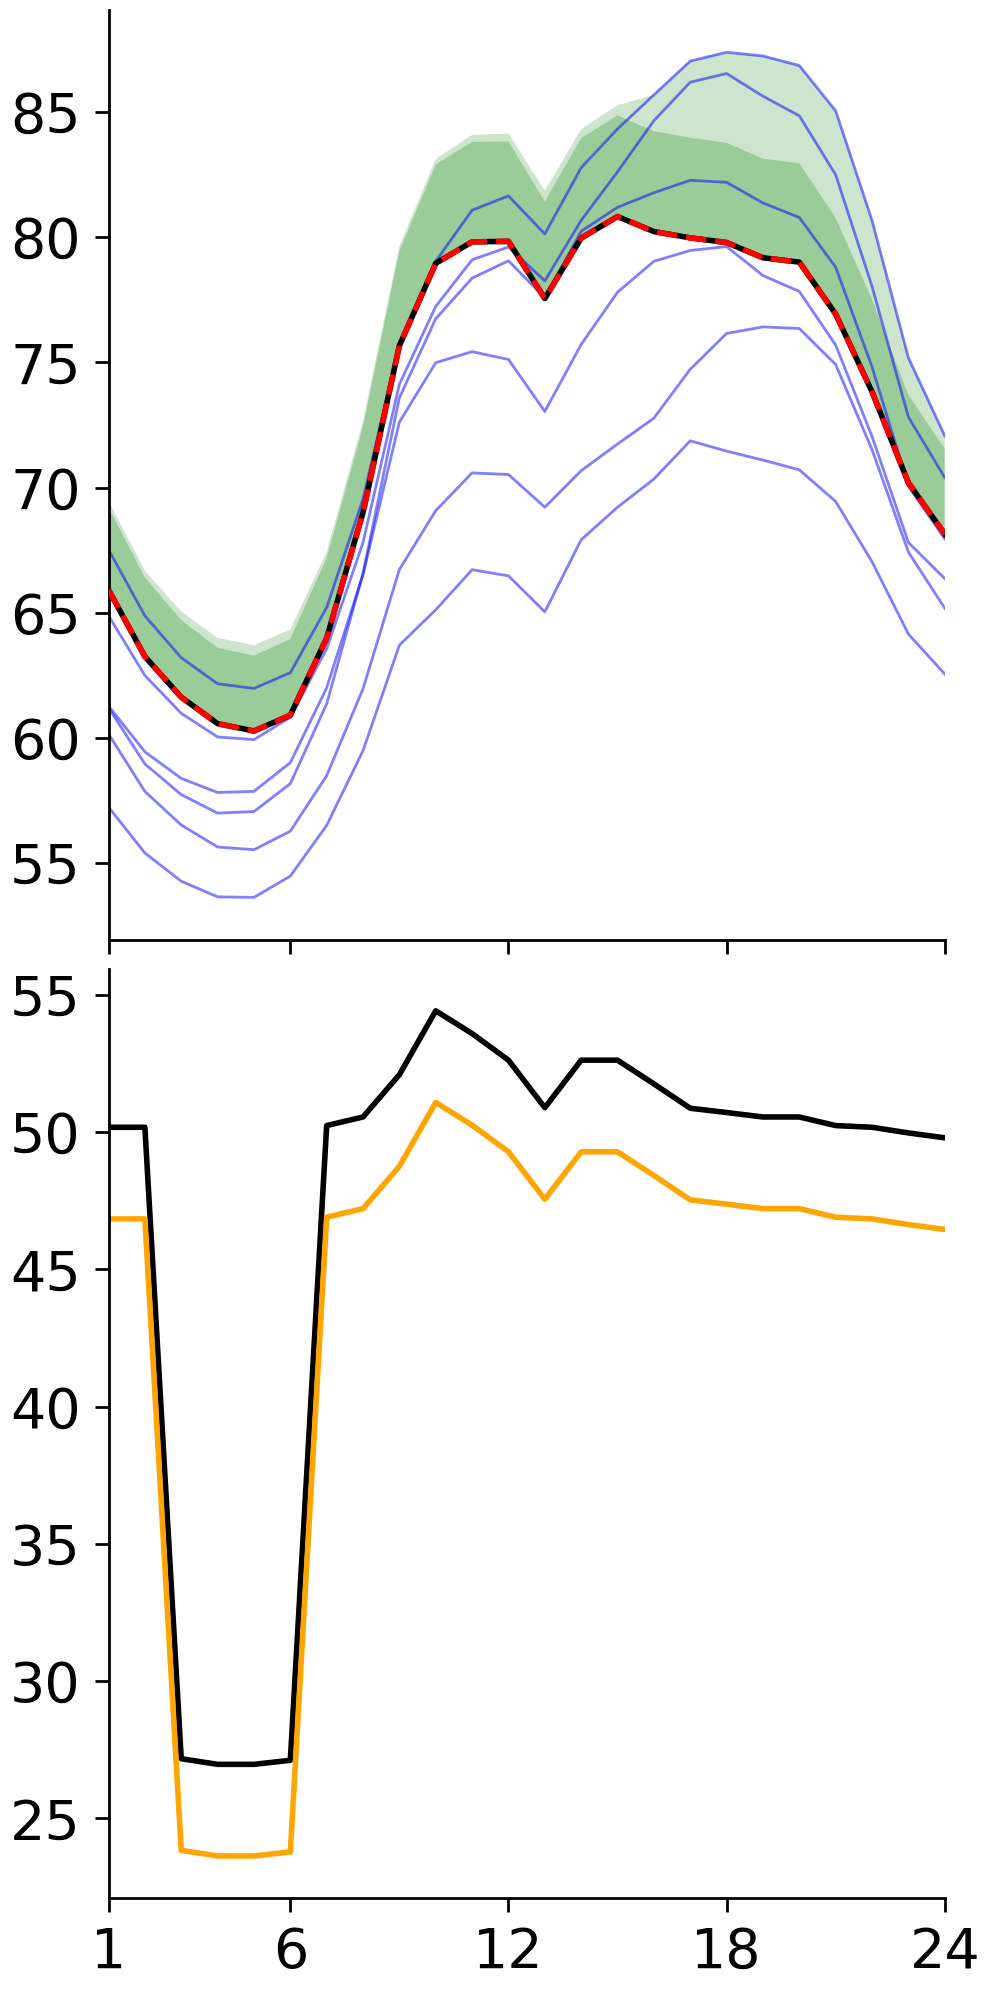

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
fig_height = 20
fig_width = 10

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(fig_width, fig_height), sharex=True, height_ratios=[1, 1])

# === Top plot: Thermal demand + reserve ===
gen = output_suc_case1.p.sum(axis=0) / 1000
res = output_suc_case1.reserve / 1000
reserve_deterministic = 0.05 * gen
reserve_extra = np.maximum(0, res - reserve_deterministic)

# deterministic reserve (base layer)
ax1.fill_between(
    x=np.arange(24),
    y1=gen,
    y2=gen + reserve_deterministic,
    color="green",
    edgecolor=None,
    alpha=0.4,
    zorder=0,
)

# extra reserve (stacked)
ax1.fill_between(
    x=np.arange(24),
    y1=gen + reserve_deterministic,
    y2=gen + res,
    color="green",
    edgecolor=None,
    alpha=0.2,
    zorder=0,
)

# thermal demand scenarios
ax1.plot(thermal_demand_scenario / 1000, c="blue", lw=2, alpha=0.5, zorder=1)

# mean scenario
# ax1.plot(thermal_demand_scenario.mean(axis=1), c="blue", lw=2, zorder=2)

# actual (forecasted) demand
ax1.plot((demand - renewable) / 1000, c="black", lw=4, zorder=3)
ax1.plot((input_suc_case1.demand_fore - input_suc_case1.renewable_fore) / 1000, c="red", lw=4, zorder=4, ls="--") 
## rnewable is 0 thats the thermal demand ok not this one this is for case 2 and rest comment

ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)

# === Bottom plot: Price curves ===
ax2.plot(output_suc_case1.marginal_price_generation / 1000, color="black", lw=4, zorder=1)
ax2.plot(output_suc_case1.marginal_price_reserve / 1000, color="orange", lw=4, zorder=2)

ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)


for ax in [ax1, ax2]:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    for side in ["bottom", "left"]:
        ax.spines[side].set_linewidth(fig_height / 10)

    ax.tick_params(
        axis="both",
        width=fig_height / 10,
        length=fig_height / 2,
        pad=fig_height / 2,
        labelsize=fig_height * 2,
    )


ax2.set_xlim(0, 23)
ax2.set_xticks([0, 5, 11, 17, 23])
ax2.set_xticklabels(np.array([0, 5, 11, 17, 23]) + 1)
plt.tight_layout()


In [12]:
output_suc_case1.nse

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

In [13]:
case1 = output_suc_case1

In [14]:
case1.objval

47386742802.75002

In [15]:
case1.total_cost_reserve / 1e9

5.2865812991777155

In [16]:
output_suc_case1.total_cost

52673324101.927734

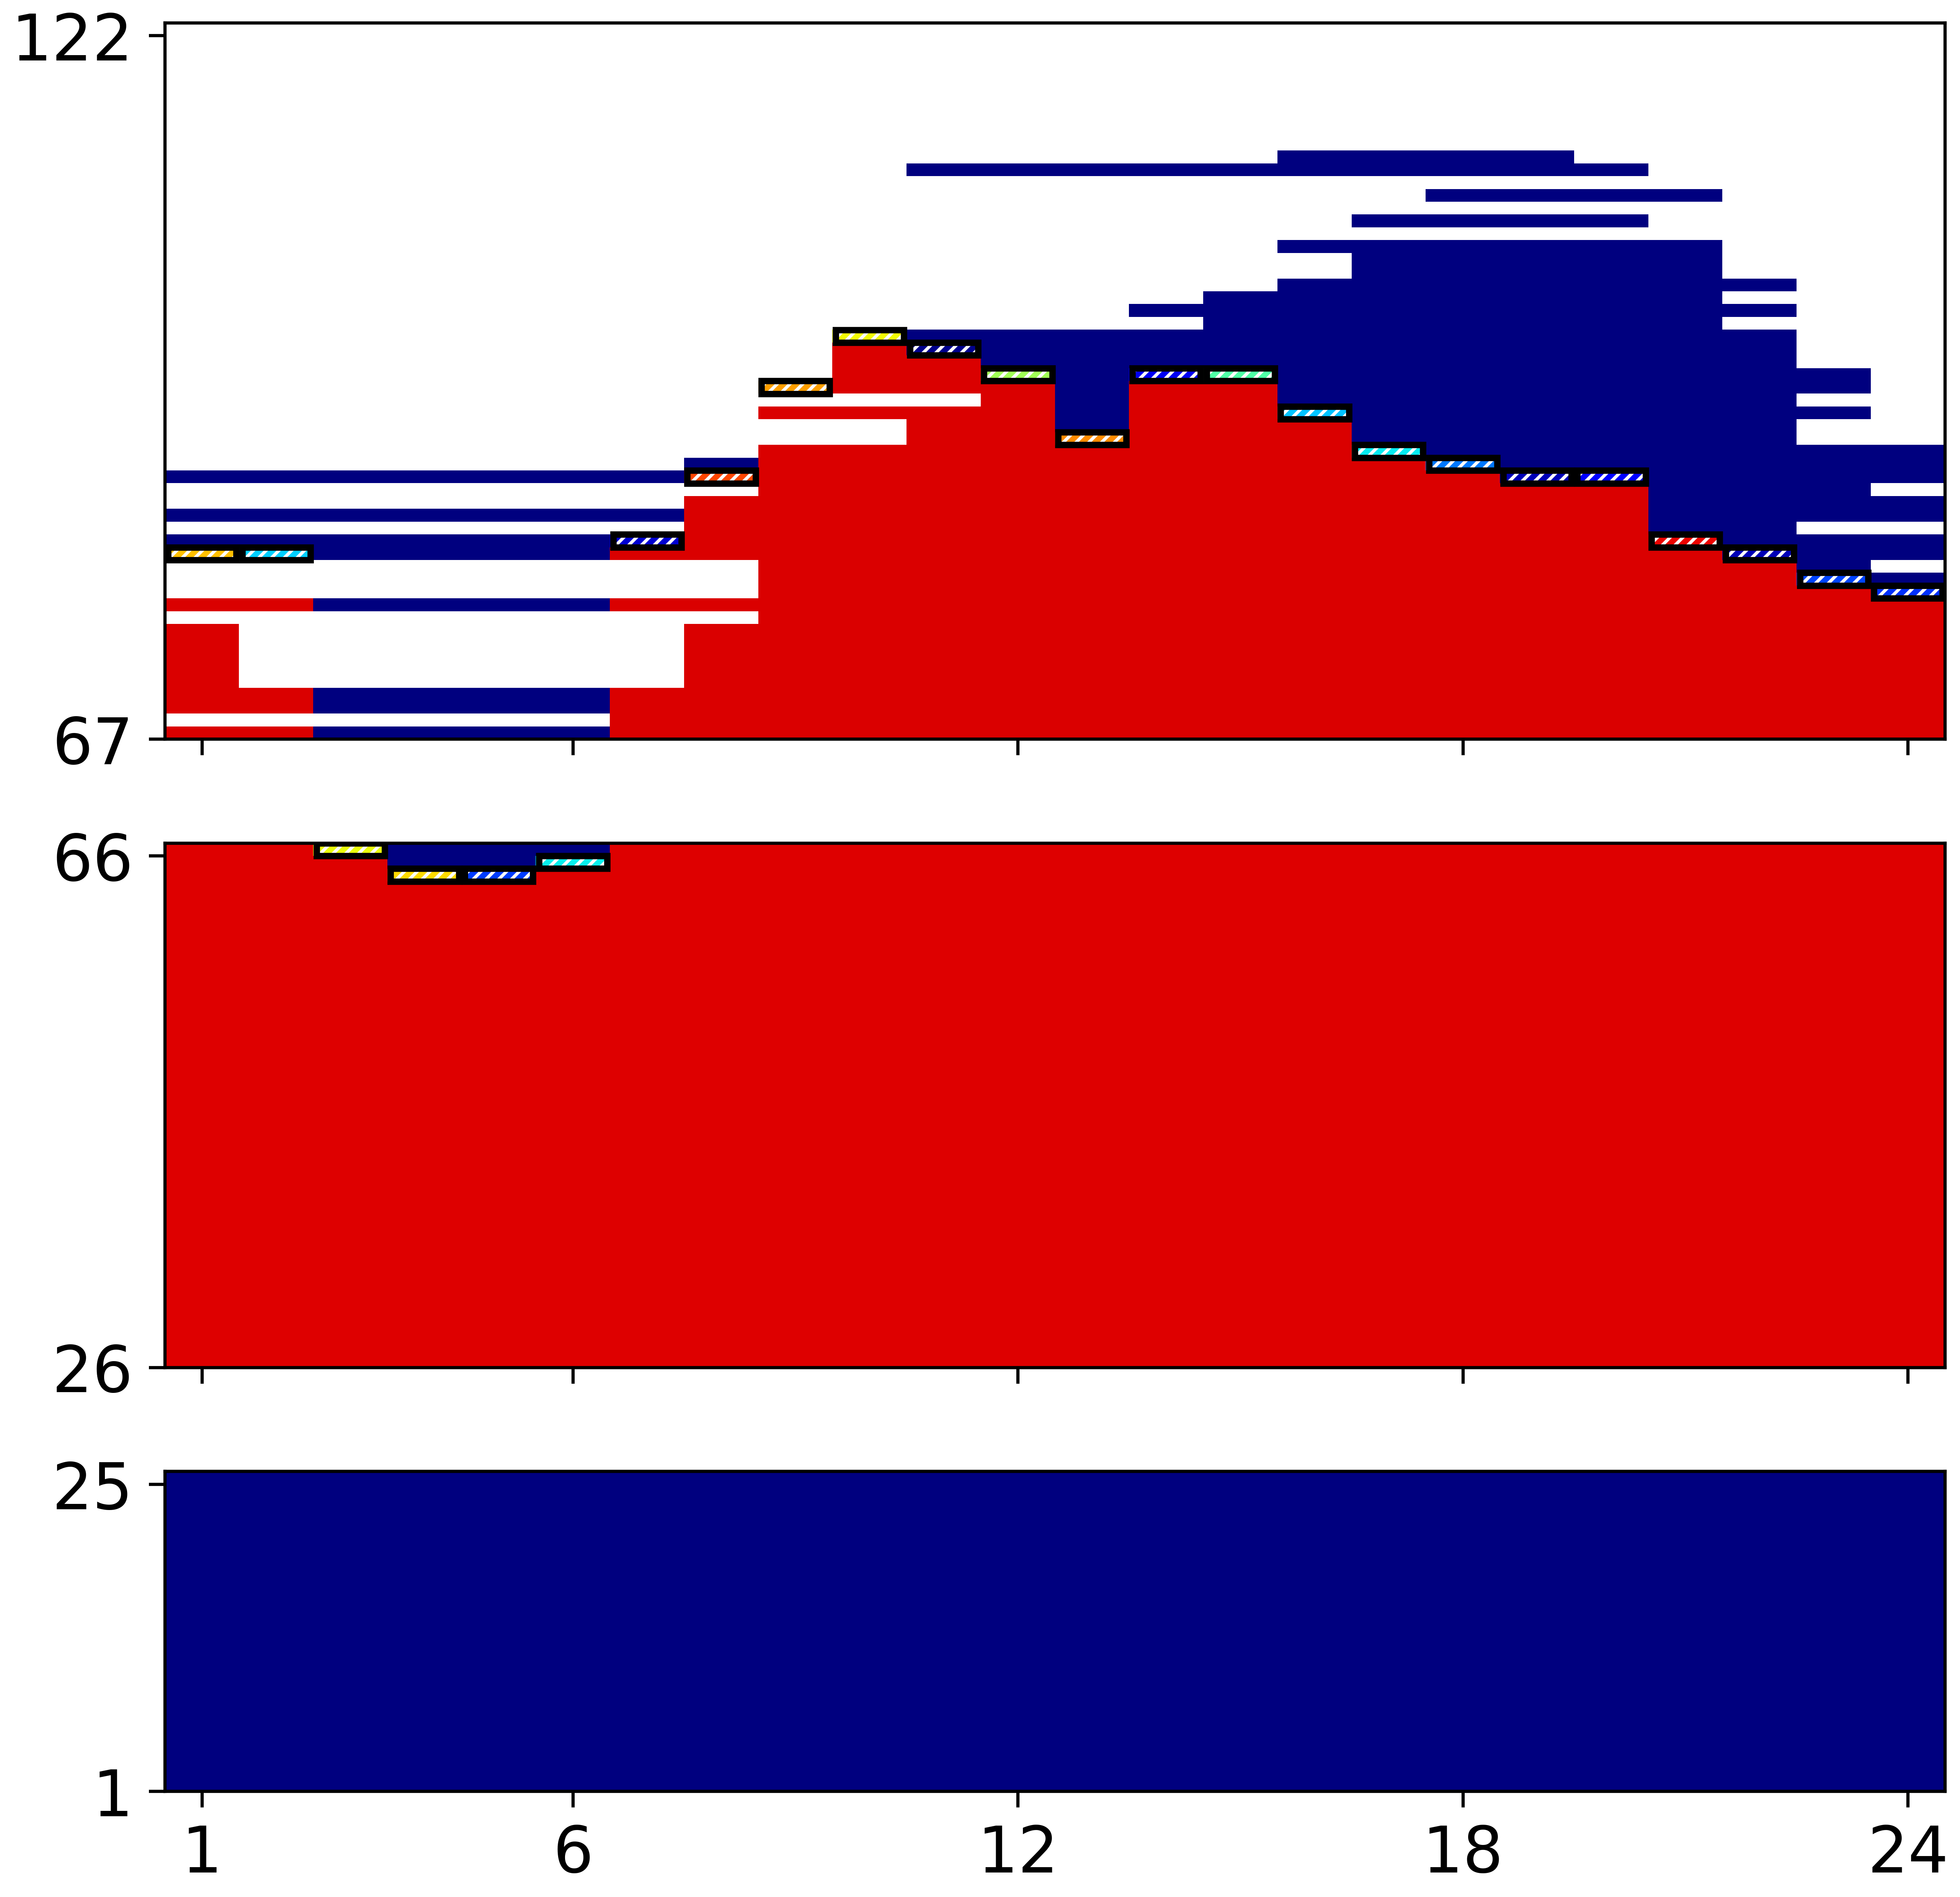

In [17]:
from src.plot import plot_schedule_heatmap
_ = plot_schedule_heatmap(input_uc=input_uc, output_uc=output_suc_case1, is_prev=False)

In [24]:
output_suc_case1.nse_scen

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0

In [ ]:
asdf

In [ ]:
asdf

In [ ]:
asdf

In [28]:
thermal_demand_scenario[:, 0]

array([57240.11321489, 55405.9193242 , 54277.18883315, 53654.2995061 ,
       53632.16836609, 54483.44653996, 56507.92863401, 59496.7847044 ,
       63703.51855091, 65119.05765438, 66719.00131062, 66473.42758159,
       65036.32860612, 67916.86505402, 69214.37933284, 70340.10888676,
       71864.94460813, 71454.05921956, 71097.15730751, 70706.56408607,
       69442.82696691, 67037.19994344, 64147.62061203, 62553.03800605])

In [12]:
input_suc_case2 = Input_suc(
    demand_fore=thermal_demand_scenario[:, 0], # lowest scenario 
    renewable_fore=np.zeros(num_periods),
    num_scenarios=6,
    thermal_demand_scenario=thermal_demand_scenario,
    scenario_p_weight=np.ones(6) / 6,
    voll=3500000,
    fr_margin_pu=0.02,
)

output_suc_case2 = Output_uc()
# solve_suc(
#     input_uc=input_uc,
#     input_suc=input_suc_case2,
#     output_suc=output_suc_case2,
#     verbose=True,
# )

# with open(path_ouptut / "output_suc_case2.pickle", "wb") as f:
#     pickle.dump(output_suc_case2, f, pickle.HIGHEST_PROTOCOL) # saving cus i will definitely have to restart this ipynb for orignal DUC stuffs


In [13]:
# solve_ed_after_suc(input_uc=input_uc, input_suc=input_suc_case2, output_suc=output_suc_case2, verbose=True)
# with open(path_ouptut / "output_suc_case2.pickle", "wb") as f:
#     pickle.dump(output_suc_case2, f, pickle.HIGHEST_PROTOCOL) # saving cus i will definitely have to restart this ipynb for orignal DUC stuffs


In [ ]:
with open(path_ouptut / "output_suc_case2.pickle", "rb") as f:
    output_suc_case2 = pickle.load(f) # saving cus i will definitely have to restart this ipynb for orignal DUC stuffs

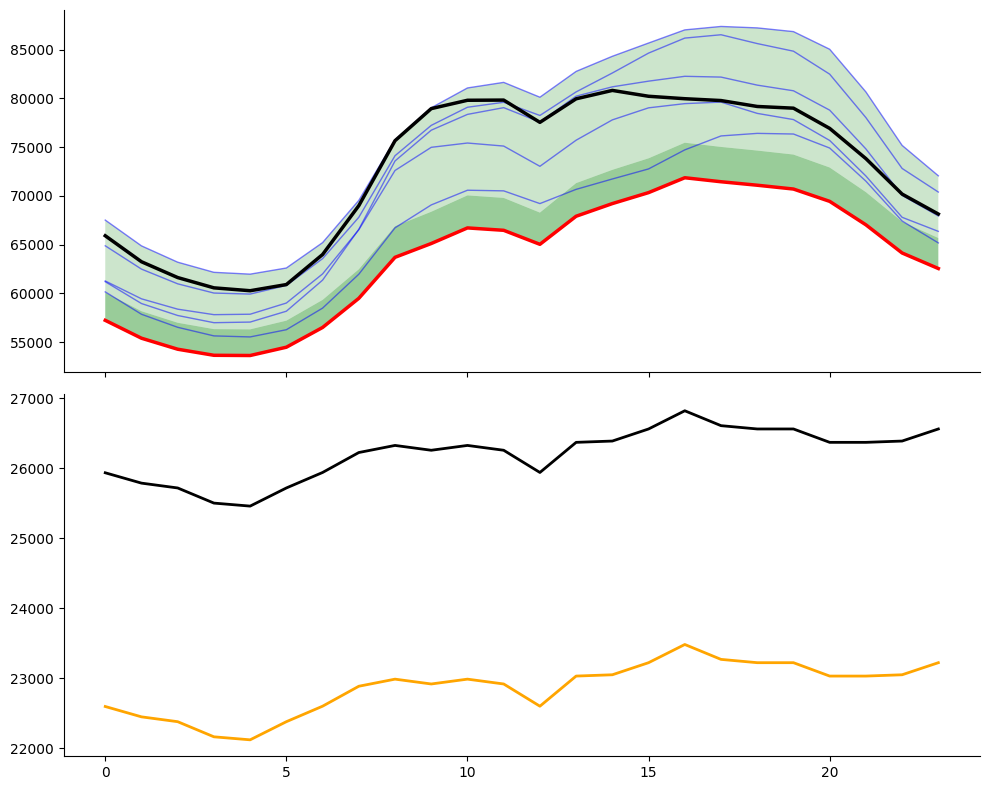

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
fig_height = 20
fig_width = 10

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(fig_width, fig_height), sharex=True, height_ratios=[1, 1])

# === Top plot: Thermal demand + reserve ===
gen = output_suc_case2.p.sum(axis=0) / 1000
res = output_suc_case2.reserve / 1000
reserve_deterministic = 0.05 * gen
reserve_extra = np.maximum(0, res - reserve_deterministic)

# deterministic reserve (base layer)
ax1.fill_between(
    x=np.arange(24),
    y1=gen,
    y2=gen + reserve_deterministic,
    color="green",
    edgecolor=None,
    alpha=0.4,
    zorder=0,
)

# extra reserve (stacked)
ax1.fill_between(
    x=np.arange(24),
    y1=gen + reserve_deterministic,
    y2=gen + res,
    color="green",
    edgecolor=None,
    alpha=0.2,
    zorder=0,
)

# thermal demand scenarios
ax1.plot(thermal_demand_scenario / 1000, c="blue", lw=2, alpha=0.5, zorder=1)

# mean scenario
# ax1.plot(thermal_demand_scenario.mean(axis=1), c="blue", lw=2, zorder=2)

# actual (forecasted) demand
ax1.plot((demand - renewable) / 1000, c="black", lw=4, zorder=3)
ax1.plot(input_suc_case2.demand_fore / 1000, c="red", lw=4, zorder=4, ls="--") # rnewable is 0 thats the thermal demand

ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)

# === Bottom plot: Price curves ===
ax2.plot(output_suc_case2.marginal_price_generation / 1000, color="black", lw=4, zorder=1)
ax2.plot(output_suc_case2.marginal_price_reserve / 1000, color="orange", lw=4, zorder=2)

ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)


for ax in [ax1, ax2]:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    for side in ["bottom", "left"]:
        ax.spines[side].set_linewidth(fig_height / 10)

    ax.tick_params(
        axis="both",
        width=fig_height / 10,
        length=fig_height / 2,
        pad=fig_height / 2,
        labelsize=fig_height * 2,
    )


ax2.set_xlim(0, 23)
ax2.set_xticks([0, 5, 11, 17, 23])
ax2.set_xticklabels(np.array([0, 5, 11, 17, 23]) + 1)
plt.tight_layout()


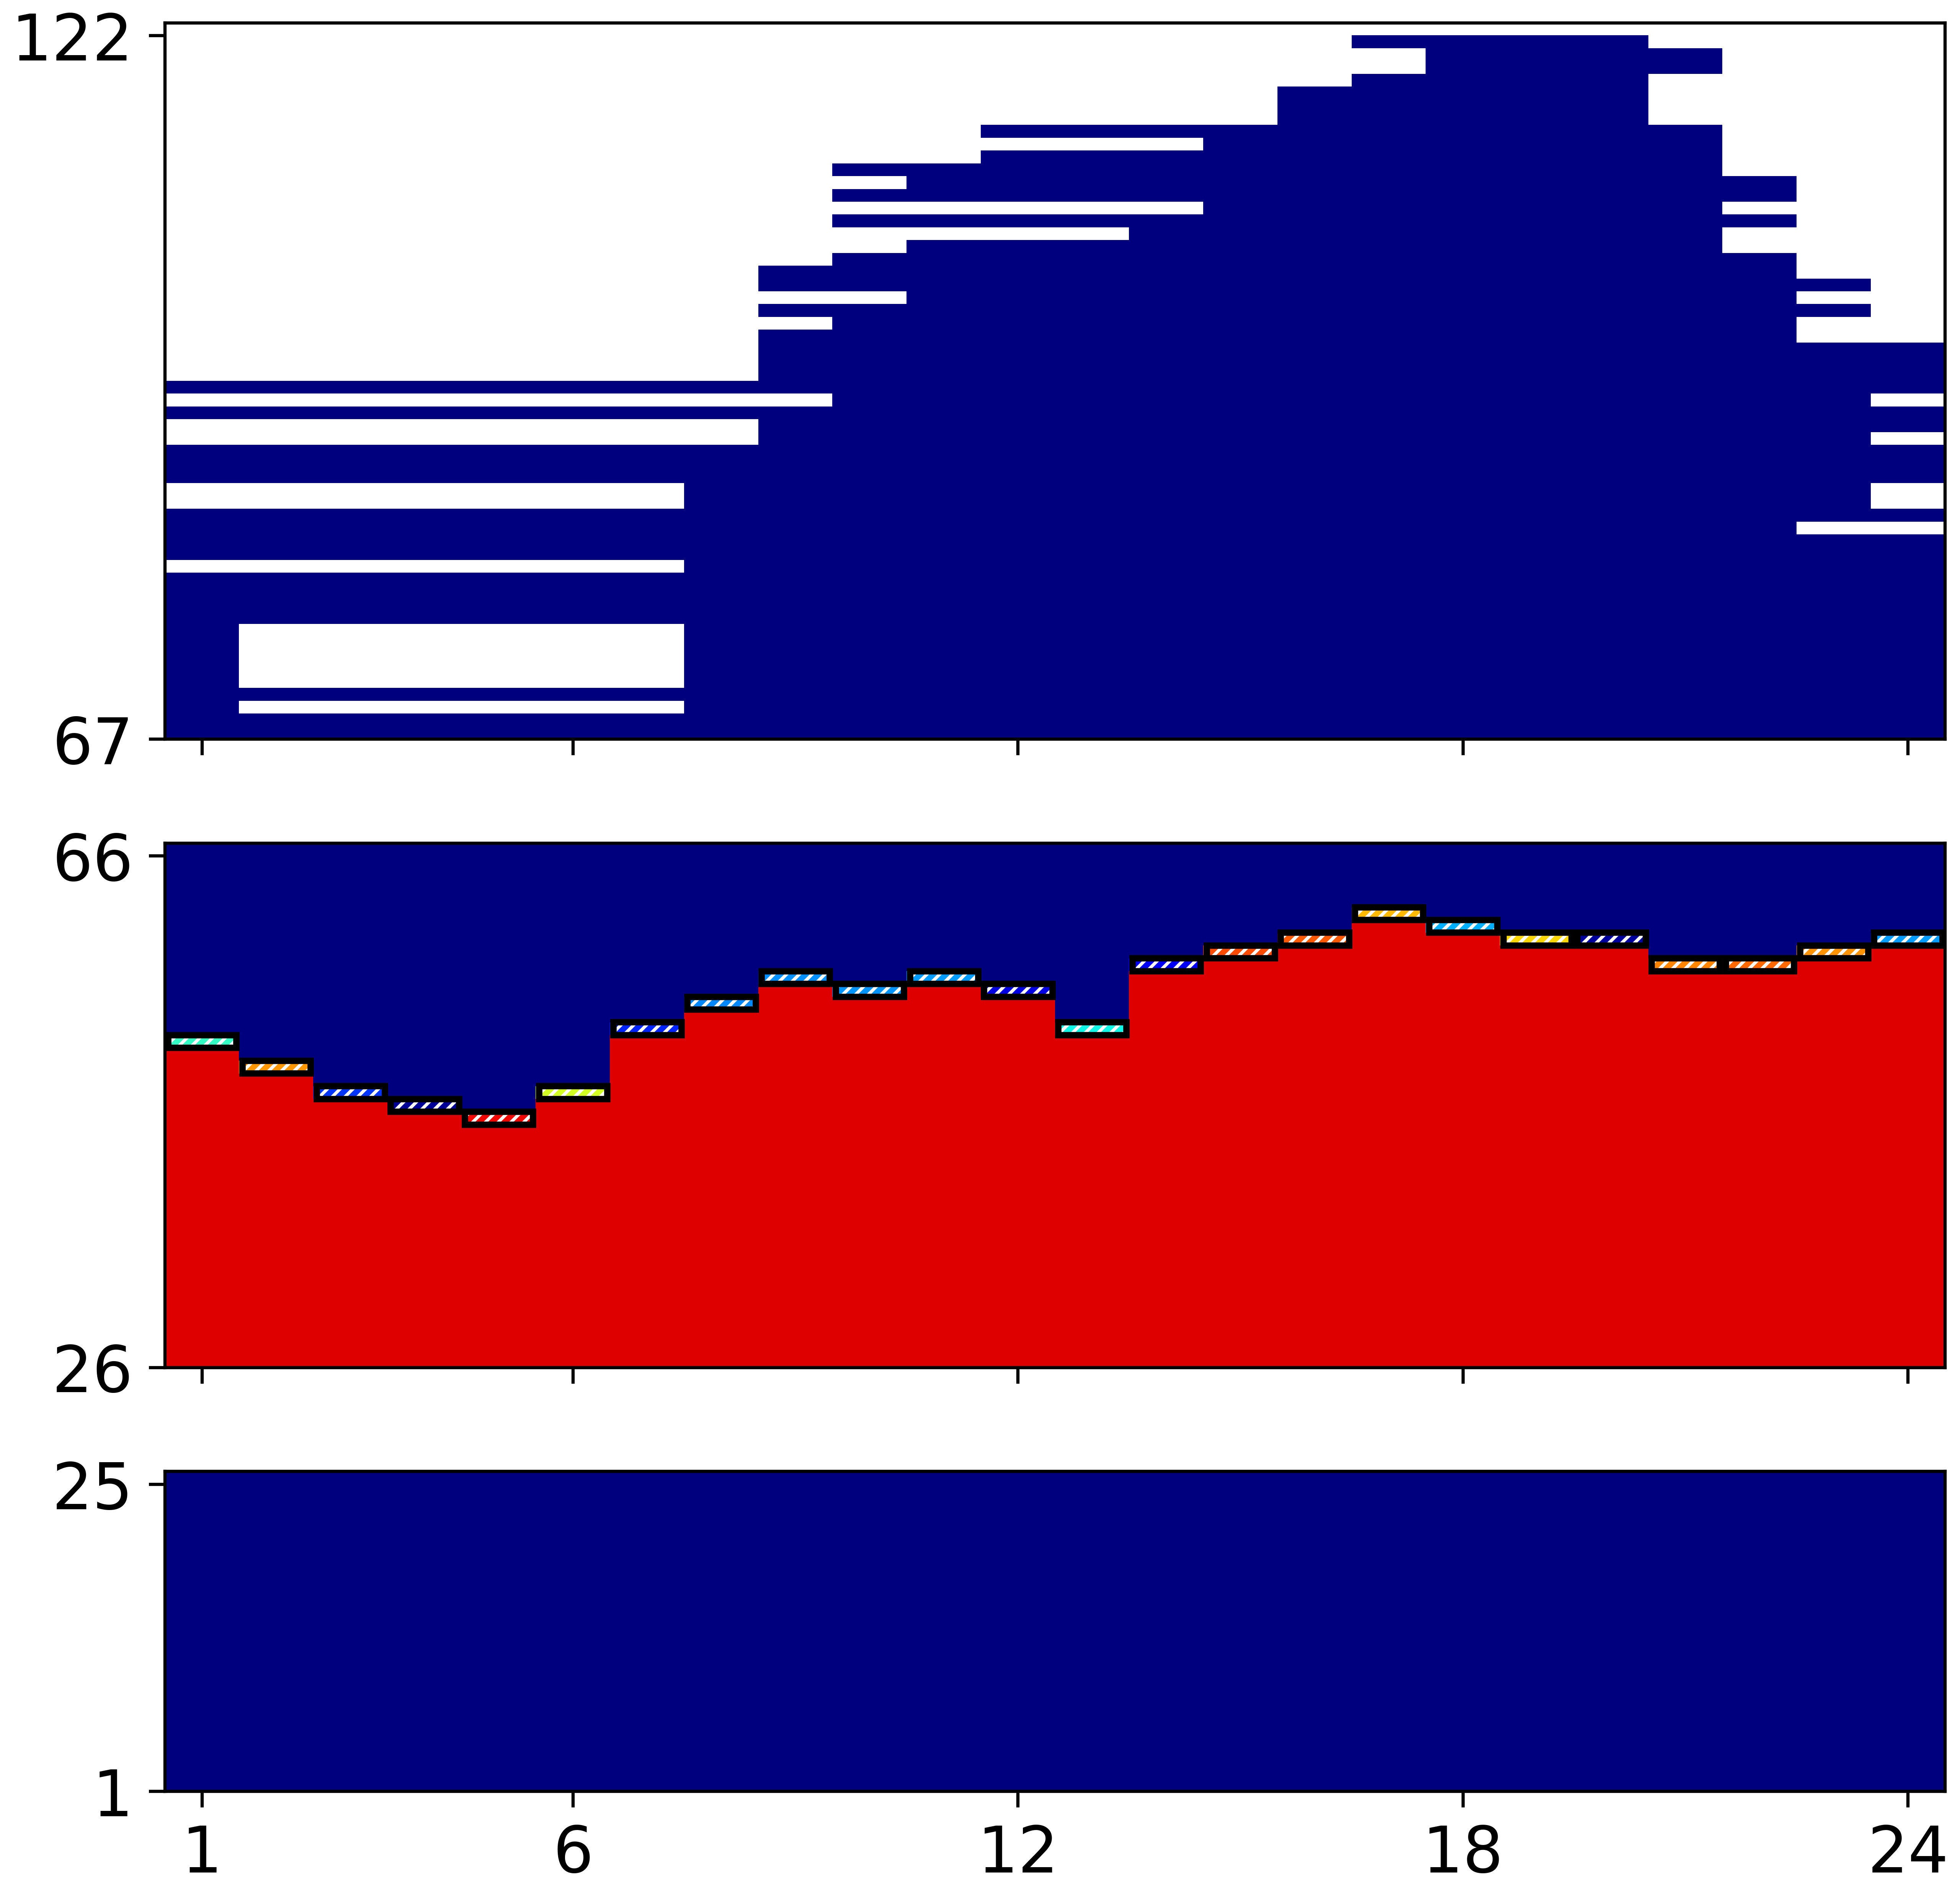

In [43]:
from src.plot import plot_schedule_heatmap
_ = plot_schedule_heatmap(input_uc=input_uc, output_uc=output_suc_case2, is_prev=False)

In [38]:
with open(path_ouptut / "output_suc_case2.pickle", "rb") as f:
    output_suc_case2 = pickle.load(f) # saving cus i will definitely have to restart this ipynb for orignal DUC stuffs

In [43]:
output_suc_case2.nse

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

In [14]:
with open(path_ouptut / "output_suc_case3.pickle", "rb") as f:
    output_suc_case3 = pickle.load(f) # saving cus i will definitely have to restart this ipynb for orignal DUC stuffs

In [ ]:
input_suc_case3 = Input_suc(
    demand_fore=thermal_demand_scenario[:, -1], # HiHGEST SCNEARIO
    renewable_fore=np.zeros(num_periods),
    num_scenarios=6,
    thermal_demand_scenario=thermal_demand_scenario,
    scenario_p_weight=np.ones(6) / 6,
    voll=3500000,
    fr_margin_pu=0.02,
)
# FROZEN
# output_suc_case3 = Output_uc()
# solve_suc(
#     input_uc=input_uc,
#     input_suc=input_suc_case3,
#     output_suc=output_suc_case3,
#     verbose=True,
# )

# # with open(path_ouptut / "output_suc_case3.pickle", "wb") as f:
# #     pickle.dump(output_suc_case3, f, pickle.HIGHEST_PROTOCOL) # saving cus i will definitely have to restart this ipynb for orignal DUC stuffs

# solve_ed_after_suc(input_uc=input_uc, input_suc=input_suc_case3, output_suc=output_suc_case3, verbose=True)
# with open(path_ouptut / "output_suc_case3.pickle", "wb") as f:
#     pickle.dump(output_suc_case3, f, pickle.HIGHEST_PROTOCOL) # saving cus i will definitely have to restart this ipynb for orignal DUC stuffs


Set parameter OutputFlag to value 1
Set parameter Symmetry to value 2
Set parameter PreDual to value 2
Set parameter Presolve to value 1
Set parameter PreSparsify to value 2
Set parameter Disconnected to value 2
Set parameter Heuristics to value 1
Set parameter ProjImpliedCuts to value 2
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Arch Linux")

CPU model: 12th Gen Intel(R) Core(TM) i7-12700, instruction set [SSE2|AVX|AVX2]
Thread count: 20 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
Disconnected  2
Heuristics  1
Symmetry  2
ProjImpliedCuts  2
PreDual  2
Presolve  1
PreSparsify  2

Optimize a model with 105622 rows, 38376 columns and 379337 nonzeros
Model fingerprint: 0xcda718cc
Variable types: 20808 continuous, 17568 integer (17568 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [6e+02, 6e+07]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+00, 9e+04]
Sparsify removed 264 nonzeros 

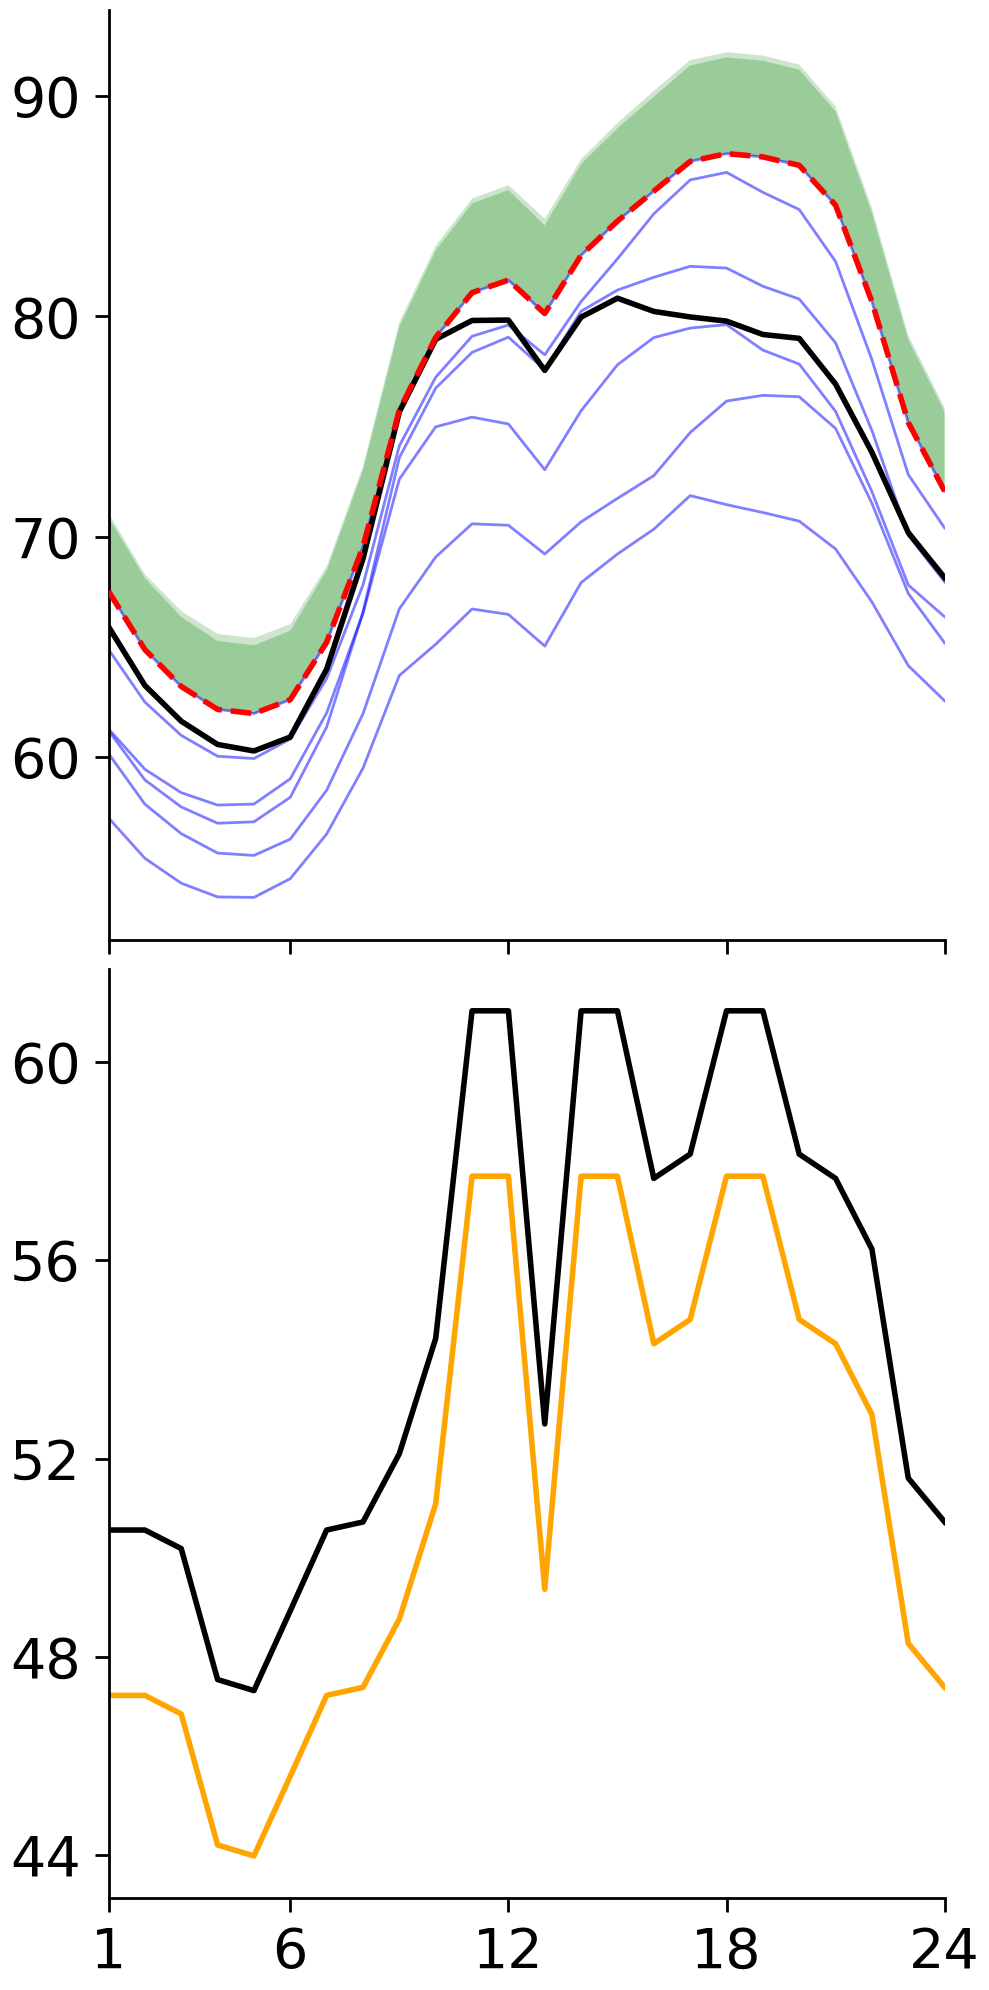

In [24]:
import matplotlib.pyplot as plt
import numpy as np
fig_height = 20
fig_width = 10

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(fig_width, fig_height), sharex=True, height_ratios=[1, 1])

# === Top plot: Thermal demand + reserve ===
gen = output_suc_case3.p.sum(axis=0) / 1000
res = output_suc_case3.reserve / 1000
reserve_deterministic = 0.05 * gen
reserve_extra = np.maximum(0, res - reserve_deterministic)

# deterministic reserve (base layer)
ax1.fill_between(
    x=np.arange(24),
    y1=gen,
    y2=gen + reserve_deterministic,
    color="green",
    edgecolor=None,
    alpha=0.4,
    zorder=0,
)

# extra reserve (stacked)
ax1.fill_between(
    x=np.arange(24),
    y1=gen + reserve_deterministic,
    y2=gen + res,
    color="green",
    edgecolor=None,
    alpha=0.2,
    zorder=0,
)

# thermal demand scenarios
ax1.plot(thermal_demand_scenario / 1000, c="blue", lw=2, alpha=0.5, zorder=1)

# mean scenario
# ax1.plot(thermal_demand_scenario.mean(axis=1), c="blue", lw=2, zorder=2)

# actual (forecasted) demand
ax1.plot((demand - renewable) / 1000, c="black", lw=4, zorder=3)
ax1.plot((input_suc_case3.demand_fore - input_suc_case3.renewable_fore) / 1000, c="red", lw=4, zorder=4, ls="--") 
## rnewable is 0 thats the thermal demand ok not this one this is for case 2 and rest comment

ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)

# === Bottom plot: Price curves ===
ax2.plot(output_suc_case3.marginal_price_generation / 1000, color="black", lw=4, zorder=1)
ax2.plot(output_suc_case3.marginal_price_reserve / 1000, color="orange", lw=4, zorder=2)

ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)


for ax in [ax1, ax2]:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    for side in ["bottom", "left"]:
        ax.spines[side].set_linewidth(fig_height / 10)

    ax.tick_params(
        axis="both",
        width=fig_height / 10,
        length=fig_height / 2,
        pad=fig_height / 2,
        labelsize=fig_height * 2,
    )


ax2.set_xlim(0, 23)
ax2.set_xticks([0, 5, 11, 17, 23])
ax2.set_xticklabels(np.array([0, 5, 11, 17, 23]) + 1)
ax2.set_yticks(np.arange(44, 64, 4))
plt.tight_layout()


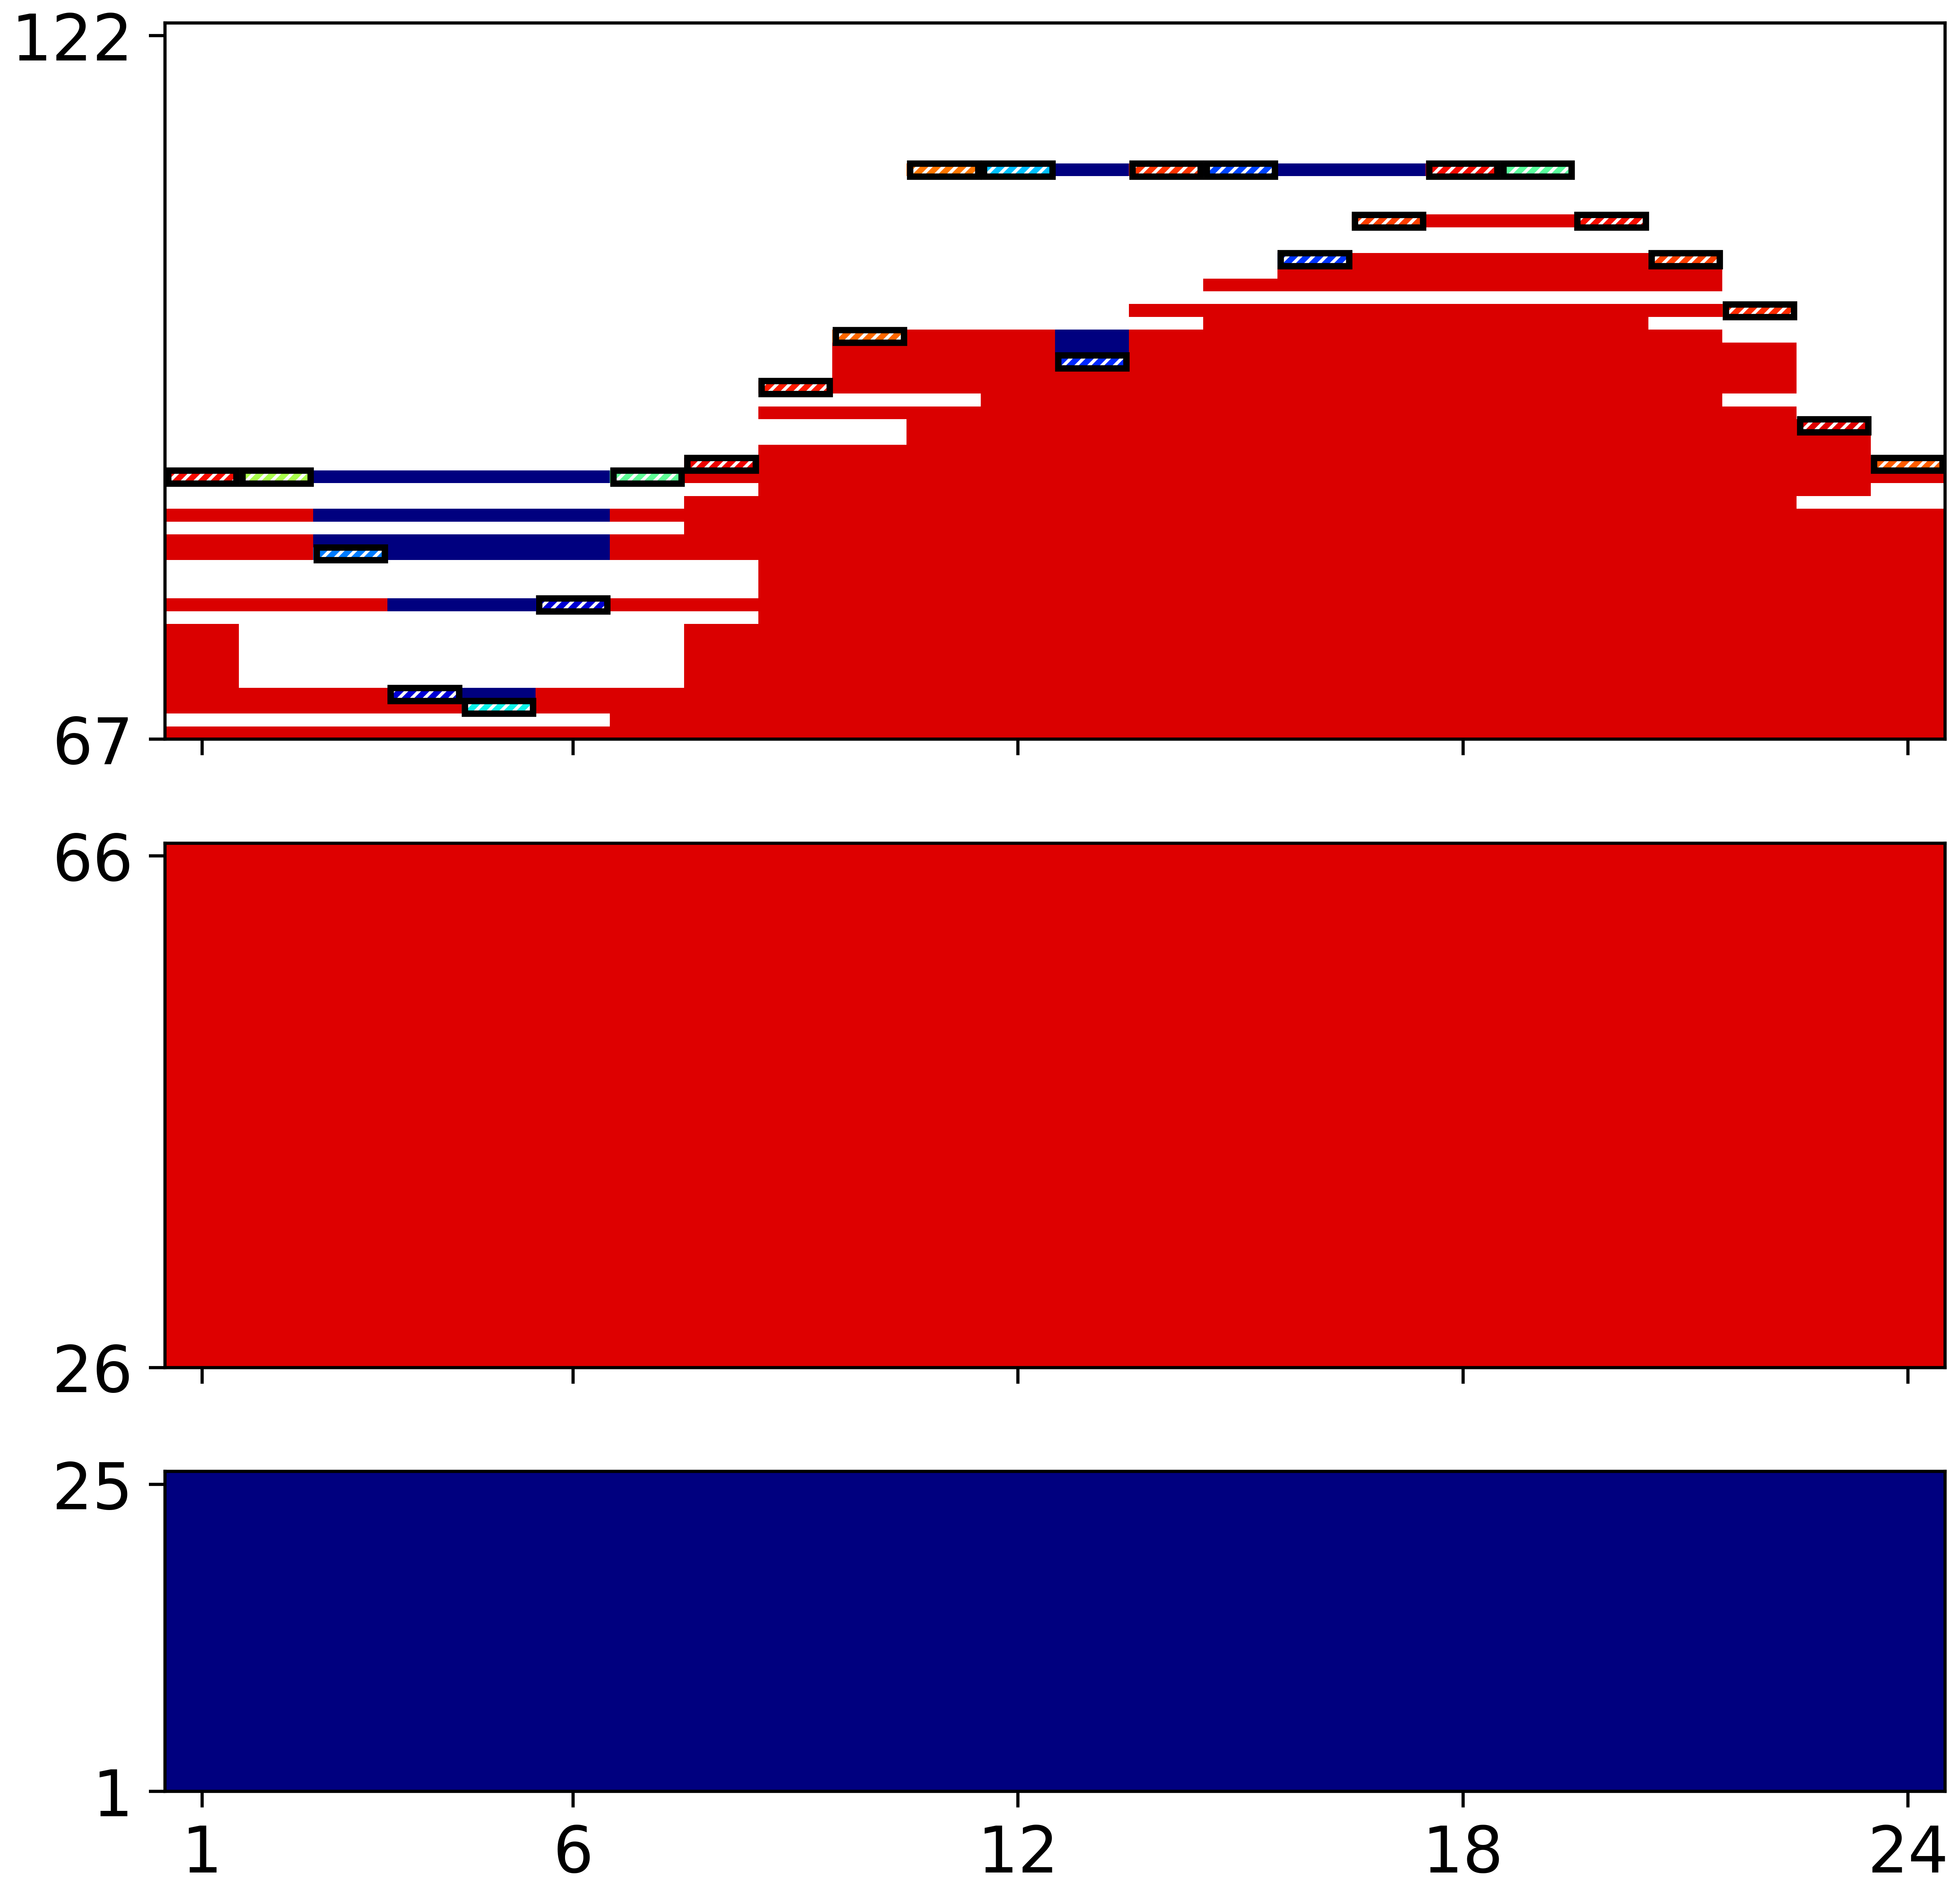

In [25]:
from src.plot import plot_schedule_heatmap
_ = plot_schedule_heatmap(input_uc=input_uc, output_uc=output_suc_case3, is_prev=False)

In [44]:
( input_uc.demand - input_uc.renewable ) - input_suc_case3.demand_fore 

array([-1607.2670308 , -1627.81495115, -1575.75888571, -1591.80495296,
       -1699.91787807, -1697.53904803, -1218.32576099,  -541.21621168,
         -77.38875356,   -84.37320953, -1262.54977328, -1815.70135223,
       -2578.02936786, -2808.36294995, -3499.22300799, -5459.20196272,
       -7059.06472981, -7599.9106593 , -8058.58804335, -7851.58705311,
       -8117.00335423, -6839.77379613, -4993.77167139, -3924.23394893])

In [59]:
output_suc_case1.total_cost_nse

0.0

In [60]:
output_suc_case1.total_cost_generation / 1e9

45.65136302474985

In [61]:
output_suc_case1.total_cost_startup / 1e9

1.735379778

In [62]:
output_suc_case3.total_cost_reserve / 1e9

5.0264818147838195

In [ ]:
(output_suc_case1.total_cost_retailer + output_suc_case3.total_cost_reserve) / 1e9
# finished project 
# do not run this code like every cell. please first save the ouptut into local / spearate folder copy them

88.65765197197494

---
---
---

In [ ]:
# voll experiment 
input_suc_case4 = Input_suc(
    demand_fore=demand,
    renewable_fore=renewable,
    num_scenarios=6,
    thermal_demand_scenario=thermal_demand_scenario,
    scenario_p_weight=np.ones(6) / 6,
    voll=350000,
    fr_margin_pu=0.02,
)

output_suc_case4 = Output_uc()
solve_suc(
    input_uc=input_uc,
    input_suc=input_suc_case4,
    output_suc=output_suc_case4,
    verbose=True,
)

with open(path_ouptut / "output_suc_case4.pickle", "wb") as f:
    pickle.dump(output_suc_case4, f, pickle.HIGHEST_PROTOCOL) # saving cus i will definitely have to restart this ipynb for orignal DUC stuffs

solve_ed_after_suc(input_uc=input_uc, input_suc=input_suc_case4, output_suc=output_suc_case4, verbose=True)
with open(path_ouptut / "output_suc_case4.pickle", "wb") as f:
    pickle.dump(output_suc_case4, f, pickle.HIGHEST_PROTOCOL) # saving cus i will definitely have to restart this ipynb for orignal DUC stuffs


Set parameter OutputFlag to value 1
Set parameter Symmetry to value 2
Set parameter PreDual to value 2
Set parameter Presolve to value 1
Set parameter PreSparsify to value 2
Set parameter Disconnected to value 2
Set parameter Heuristics to value 1
Set parameter ProjImpliedCuts to value 2
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Arch Linux")

CPU model: 12th Gen Intel(R) Core(TM) i7-12700, instruction set [SSE2|AVX|AVX2]
Thread count: 20 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
Disconnected  2
Heuristics  1
Symmetry  2
ProjImpliedCuts  2
PreDual  2
Presolve  1
PreSparsify  2

Optimize a model with 105622 rows, 38376 columns and 379337 nonzeros
Model fingerprint: 0xf80b8a9d
Variable types: 20808 continuous, 17568 integer (17568 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [6e+02, 6e+07]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+00, 9e+04]
Sparsify removed 2170 nonzeros

In [55]:
output_suc_case4.cost_nse

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

In [ ]:
# voll experiment 
input_suc_case5 = Input_suc(
    demand_fore=demand, # lowest scenario 
    renewable_fore=renewable,
    num_scenarios=6,
    thermal_demand_scenario=thermal_demand_scenario,
    scenario_p_weight=np.ones(6) / 6,
    voll=35000,
    fr_margin_pu=0.02,
)

output_suc_case5 = Output_uc()
solve_suc(
    input_uc=input_uc,
    input_suc=input_suc_case5,
    output_suc=output_suc_case5,
    verbose=True,
)

with open(path_ouptut / "output_suc_case5.pickle", "wb") as f:
    pickle.dump(output_suc_case5, f, pickle.HIGHEST_PROTOCOL) # saving cus i will definitely have to restart this ipynb for orignal DUC stuffs

solve_ed_after_suc(input_uc=input_uc, input_suc=input_suc_case5, output_suc=output_suc_case5, verbose=True)
with open(path_ouptut / "output_suc_case5.pickle", "wb") as f:
    pickle.dump(output_suc_case5, f, pickle.HIGHEST_PROTOCOL) # saving cus i will definitely have to restart this ipynb for orignal DUC stuffs


Set parameter OutputFlag to value 1
Set parameter Symmetry to value 2
Set parameter PreDual to value 2
Set parameter Presolve to value 1
Set parameter PreSparsify to value 2
Set parameter Disconnected to value 2
Set parameter Heuristics to value 1
Set parameter ProjImpliedCuts to value 2
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Arch Linux")

CPU model: 12th Gen Intel(R) Core(TM) i7-12700, instruction set [SSE2|AVX|AVX2]
Thread count: 20 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
Disconnected  2
Heuristics  1
Symmetry  2
ProjImpliedCuts  2
PreDual  2
Presolve  1
PreSparsify  2

Optimize a model with 105622 rows, 38376 columns and 379337 nonzeros
Model fingerprint: 0x23310e9a
Variable types: 20808 continuous, 17568 integer (17568 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [6e+02, 6e+07]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+00, 9e+04]
Sparsify removed 2170 nonzeros